In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from airsenal.framework.schema import Player, PlayerScore, session
from airsenal.framework.utils import list_players

%matplotlib inline

In [2]:
min_minutes = 90
min_matches = 10
gameweek = 3
season = "2021"

Text(0.5, 0, 'Save points')

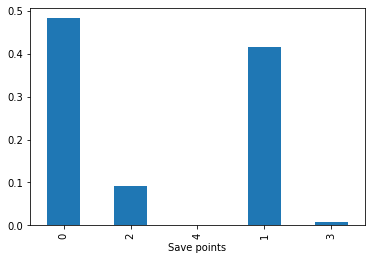

In [3]:
goalkeepers = list_players(position="GK", gameweek=gameweek, season=season)
goalkeepers = [gk.player_id for gk in goalkeepers]

query = (
    session.query(PlayerScore)
    .join(Player)
    .filter(Player.player_id.in_(goalkeepers))
    .filter(PlayerScore.minutes >= min_minutes)
)
# TODO filter on gw and season
df = pd.read_sql(query.statement, session.bind)

# 1pt per 3 saves
df["save_pts"] = (df["saves"] / 3).astype(int)


df["save_pts"].value_counts(normalize=True, sort=False).plot.bar()
plt.xlabel("Save points")

<AxesSubplot:xlabel='saves', ylabel='Probability'>

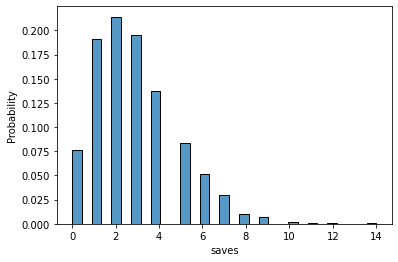

In [4]:
sns.histplot(df["saves"], stat="probability")

In [5]:
def fit_save_points(gameweek, season, min_matches=10, min_minutes=90):
    goalkeepers = list_players(position="GK", gameweek=gameweek, season=season)
    goalkeepers = [gk.player_id for gk in goalkeepers]

    query = (
        session.query(PlayerScore)
        .join(Player)
        .filter(Player.player_id.in_(goalkeepers))
        .filter(PlayerScore.minutes >= min_minutes)
    )
    # TODO filter on gw and season
    df = pd.read_sql(query.statement, session.bind)

    # 1pt per 3 saves
    df["save_pts"] = (df["saves"] / 3).astype(int)

    match_counts = df.groupby("player_id").save_pts.count()
    match_counts[match_counts < min_matches] = min_matches

    sum_saves = df.groupby("player_id").save_pts.sum()

    return sum_saves / match_counts


def get_save_points(player_id, minutes, df_saves):
    if minutes >= 60:
        if player_id in df_saves.index:
            return df_saves.loc[player_id].iloc[0]
        return 0
    return 0

In [6]:
avg_saves = fit_save_points(gameweek, season, min_matches, min_minutes)

In [7]:
players = pd.read_sql(session.query(Player).statement, session.bind)
players.set_index("player_id", inplace=True)

avg_saves = pd.merge(avg_saves, players, how="left", left_index=True, right_index=True)
avg_saves.sort_values(by="save_pts", ascending=False)

save_pts  fpl_api_id                            name
player_id                                                      
314        1.000000       213.0                   Illan Meslier
577        1.000000       417.0                   Sam Johnstone
34         0.966667        12.0               Emiliano Martínez
605        0.900000       433.0            Roberto Jimenez Gago
435        0.882353       325.0                     Karl Darlow
603        0.861789       431.0                Lukasz Fabianski
483        0.838710       483.0                  Aaron Ramsdale
167        0.787234       126.0                 Wayne Hennessey
519        0.772727       523.0                  Fraser Forster
541        0.761905       393.0                 Paulo Gazzaniga
122        0.760417        96.0                       Nick Pope
8          0.743902         8.0                      Bernd Leno
169        0.743590       128.0                  Vicente Guaita
556        0.736842       482.0                        Joe Hart
254        0.708333       516.0                 Alphonse Areola
35         0.707317        28.0                      Tom Heaton
436        0.693182       326.0                 Martin Dubravka
507        0.681818       371.0                      Angus Gunn
331        0.666667       245.0  Adrián San Miguel del Castillo
531        0.663717       383.0                     Hugo Lloris
25         0.655738        70.0                     Mathew Ryan
408        0.631579       305.0                  Dean Henderson
499        0.595745       363.0                   Alex McCarthy
205        0.586466       157.0                 Jordan Pickford
264        0.568182       217.0               Kasper Schmeichel
199        0.544118       151.0                     Jonas Lössl
395        0.531250       291.0                    David de Gea
241        0.500000       183.0               Marcus Bettinelli
633        0.480000       455.0   Rui Pedro dos Santos Patrício
138        0.454545       101.0                 Willy Caballero
229        0.400000       171.0         Fabricio Agosto Ramírez
565        0.400000        56.0                    David Button
147        0.383562       112.0               Kepa Arrizabalaga
338        0.325581       252.0           Alisson Ramses Becker
162        0.300000       548.0                   Edouard Mendy
601        0.300000       429.0                    David Martin
371        0.292308       278.0       Ederson Santana de Moraes
42         0.200000        35.0                    Ørjan Nyland
631        0.100000       453.0                      John Ruddy
602        0.100000       430.0                 Darren Randolph
393        0.100000       289.0                   Sergio Romero
469        0.100000       348.0                     Simon Moore
383        0.000000       538.0                    Zack Steffen
244        0.000000       186.0                     Marek Rodák
125        0.000000        99.0          Bailey Peacock-Farrell
295        0.000000       194.0        Francisco Casilla Cortés
360        0.000000       267.0                   Claudio Bravo

In [8]:
get_save_points(96, 90, avg_saves)

0